# MUTI CLASIFICATION LUNG

In [ ]:
# !pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch import device
from torchvision import transforms

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

/media/rafihaqul/FC86902B868FE50C/Documents/AMIKOM/skripsi/project_1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## LOAD DATASET

In [ ]:
# Load train and validation data
train_df = pd.read_csv('datasets/CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv('datasets/CheXpert-v1.0-small/valid.csv')

if 'train_df' in locals() and 'valid_df' in locals():
    print("dataset loaded")
else:
    print("fail load dataset")

dataset loaded


In [ ]:
# Display first 5 rows of validation data
train_df.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0
223413,CheXpert-v1.0-small/train/patient64540/study1/...,Female,0,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
train_df.describe()

,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,223414.000000,22381.0,44839.000000,46203.000000,117778.000000,11944.000000,85956.000000,70622.000000,27608.000000,68443.000000,78934.000000,133211.000000,6492.000000,12194.000000,123217.000000
mean,60.430653,1.0,-0.035795,0.409346,0.848911,0.644508,0.456769,-0.183498,-0.461134,-0.005304,0.206540,0.559706,0.134011,0.688699,0.932680
std,17.820925,0.0,0.718442,0.769323,0.472571,0.691607,0.741785,0.753980,0.828249,0.990244,0.493529,0.648859,0.966183,0.565435,0.283377
min,0.000000,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,49.000000,1.0,-1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000
50%,62.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,74.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Cetak jumlah data unik pada setiap kolom di train_df (kecuali 'Path')
print("Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):")
unique_counts = train_df.loc[:, ~train_df.columns.isin(['Path'])].nunique()
unique_values = train_df.loc[:, ~train_df.columns.isin(['Path'])].apply(lambda x: [str(val) for val in x.unique()])
result = pd.DataFrame({'Unique Count': unique_counts, 'Unique Values': unique_values.apply(lambda x: ', '.join(x))})
print(result)


Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):
                            Unique Count  \
Sex                                    3   
Age                                   74   
Frontal/Lateral                        2   
AP/PA                                  4   
No Finding                             1   
Enlarged Cardiomediastinum             3   
Cardiomegaly                           3   
Lung Opacity                           3   
Lung Lesion                            3   
Edema                                  3   
Consolidation                          3   
Pneumonia                              3   
Atelectasis                            3   
Pneumothorax                           3   
Pleural Effusion                       3   
Pleural Other                          3   
Fracture                               3   
Support Devices                        3   

                                                                Unique Values  
Sex               

### Check nilai ambigu (-1.0)

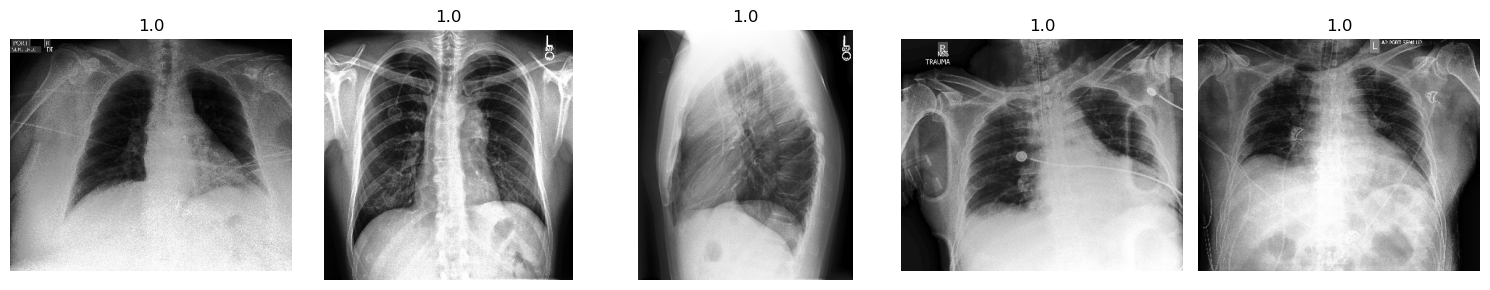

In [ ]:
# Ambil 5 baris dari train_df yang label 'Support Devices' bernilai -1.0
support_device_neg1 = train_df[train_df['Support Devices'] == 1.0].head(5)

plt.figure(figsize=(15, 3))
for i, (_, row) in enumerate(support_device_neg1.iterrows()):
    img_path = 'datasets/' + row['Path']
    image = Image.open(img_path).convert('RGB')
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{row['Support Devices']}")
plt.tight_layout()
plt.show()

>Dari hasil penelitian diatas bahwa uncurtain (-1.0) pada `'Support Devices'` cenderung positive (1.0). peneliti melabeli uncertain karena bahwa kondisi yang ada digambar tidak tampak terlihat jelas

### Check imbalance data

In [ ]:
# Ubah semua nilai -1.0 menjadi 1.0 pada kolom label di train_df dan valid_df
label_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

imbalance_check_train = train_df[label_cols].replace(-1.0, 1.0)
imbalance_check_valid = valid_df[label_cols].replace(-1.0, 1.0)

Distribusi Label:
No Finding                     22419
Enlarged Cardiomediastinum     23310
Cardiomegaly                   35155
Lung Opacity                  111305
Lung Lesion                    10675
Edema                          65275
Consolidation                  42558
Pneumonia                      24817
Atelectasis                    67195
Pneumothorax                   22601
Pleural Effusion               97882
Pleural Other                   6177
Fracture                        9682
Support Devices               117187
dtype: int64

Rasio Imbalance: 18.97
Label paling banyak: Support Devices dengan 117187 kemunculan
Label paling sedikit: Pleural Other dengan 6177 kemunculan


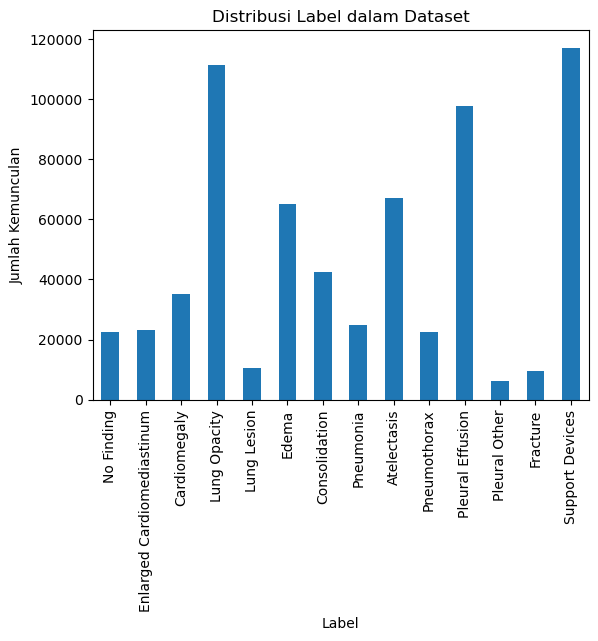

In [ ]:
# Ambil 14 label terakhir dari kolom train_df dan valid_df, hitung distribusi label (jumlah 1.0)
train_label_counts = (imbalance_check_train == 1.0).sum()
valid_label_counts = (imbalance_check_valid == 1.0).sum()
label_counts = train_label_counts + valid_label_counts

print("Distribusi Label:")
print(label_counts)

max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\nRasio Imbalance: {imbalance_ratio:.2f}")
print(f"Label paling banyak: {label_counts.idxmax()} dengan {max_count} kemunculan")
print(f"Label paling sedikit: {label_counts.idxmin()} dengan {min_count} kemunculan")

label_counts.plot(kind='bar')
plt.title('Distribusi Label dalam Dataset')
plt.ylabel('Jumlah Kemunculan')
plt.xlabel('Label')
plt.show()

## PRE PROSESING OLD DATA

### combline dataset

In [ ]:
# Gabungkan train_df dan valid_df menjadi satu dataframe
combined_df = pd.concat([train_df, valid_df], ignore_index=True)
print(f"combined_df shape: {combined_df.shape}")

del train_df
del valid_df

combined_df shape: (223648, 19)


FIlter Range Data `age`

In [ ]:
# # Drop data dari umur 0 sampai 50 pada train_df dan valid_df
# train_df = train_df[train_df['Age'] > 50].reset_index(drop=True)
# valid_df = valid_df[valid_df['Age'] > 50].reset_index(drop=True)

# print(f"train_df shape setelah drop umur <= 50: {train_df.shape}")
# print(f"valid_df shape setelah drop umur <= 50: {valid_df.shape}")

### Inisialisasi label

In [ ]:
# Inisialisasi label yang dibutuhkan
label_cols = [
    # 'Enlarged Cardiomediastinum', 
    'Cardiomegaly',
    'Lung Opacity', 
    # 'Lung Lesion', 
    'Edema', 
    # 'Consolidation',
    # 'Pneumonia', 
    'Atelectasis', 
    'Pneumothorax', 
    'Pleural Effusion',
    'Fracture'
]

### Drop coloum

In [ ]:
# Hapus baris pada train_df dan valid_df di mana kolom 'Frontal/Lateral' bernilai 'Lateral'
combined_df = combined_df[combined_df['Frontal/Lateral'] != 'Lateral'].reset_index(drop=True)

print(f"combined_df shape setelah drop Frontal/Lateral == 'Lateral': {combined_df.shape}")

combined_df shape setelah drop Frontal/Lateral == 'Lateral': (191229, 19)


In [ ]:
# Hapus kolom yang tidak diperlukan
columns_to_drop = ['Sex', 
                   'Age', 
                   'Frontal/Lateral', 
                   'AP/PA',
                   'Pleural Other',
                   'Support Devices',
                   'No Finding',
                   'Lung Lesion',
                   'Consolidation',
                   'Pneumonia',
                   'Enlarged Cardiomediastinum',
                   ]
combined_df = combined_df.drop(columns=columns_to_drop)

print(f"Kolom {columns_to_drop} yang tidak diperlukan telah dihapus.")

Kolom ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'Pleural Other', 'Support Devices', 'No Finding', 'Lung Lesion', 'Consolidation', 'Pneumonia', 'Enlarged Cardiomediastinum'] yang tidak diperlukan telah dihapus.


#### Drop/modif ambigu

In [ ]:
combined_df = combined_df[~(combined_df[label_cols] == -1.0).any(axis=1)].replace(-1.0, 1.0)

print(f"Jumlah data train setelah drop baris dengan -1.0 di kolom label: {combined_df.shape[0]}")

Jumlah data train setelah drop baris dengan -1.0 di kolom label: 136454


In [ ]:
# # Drop baris pada train_df dan valid_df yang memiliki nilai -1.0 pada kolom label
# combined_df = combined_df[~(combined_df[label_cols] == -1.0).any(axis=1)].reset_index(drop=True)

# print(f"combined_df shape setelah drop: {combined_df.shape}")

## PRE PROSESING NEW DATA

### Modifikasi label

In [ ]:
# Membuat dataset baru untuk train_df: path -> [label1, label2, ...] hanya untuk label dengan nilai 1.0
label_columns = combined_df.columns[1:]  # kolom label (kecuali 'Path')
combined_df2 = []
for idx, row in combined_df.iterrows():
    labels = [col for col in label_columns if row[col] == 1.0]
    combined_df2.append({
        'Path': row['Path'], 
        'Labels': labels})

# Contoh hasil
print("Contoh train_df2:")
for item in combined_df2[:20]:
    print(f"{item['Path']} : {item['Labels']}")

del label_columns

Contoh train_df2:
CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg : []
CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg : ['Lung Opacity', 'Fracture']
CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg : ['Edema']
CheXpert-v1.0-small/train/patient00004/study1/view1_frontal.jpg : []
CheXpert-v1.0-small/train/patient00005/study1/view1_frontal.jpg : []
CheXpert-v1.0-small/train/patient00005/study2/view1_frontal.jpg : ['Pneumothorax']
CheXpert-v1.0-small/train/patient00005/study2/view2_frontal.jpg : ['Pneumothorax']
CheXpert-v1.0-small/train/patient00006/study1/view1_frontal.jpg : []
CheXpert-v1.0-small/train/patient00007/study1/view1_frontal.jpg : ['Cardiomegaly', 'Lung Opacity', 'Atelectasis', 'Pneumothorax']
CheXpert-v1.0-small/train/patient00007/study2/view1_frontal.jpg : ['Lung Opacity', 'Atelectasis']
CheXpert-v1.0-small/train/patient00008/study1/view1_frontal.jpg : ['Lung Opacity', 'Pleural Effusion']
CheXpert-v1.0-small/train/patient00008

### split dataset

In [223]:
from sklearn.model_selection import train_test_split

# Split combined_df menjadi train (60%), validasi (20%), test (20%)
# Split combined_df2 (list of dict) menjadi train/valid/test dengan proporsi 60/20/20

train_df, temp_df = train_test_split(combined_df2, test_size=0.4, random_state=42, shuffle=True)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

# Untuk konsistensi dengan variabel sebelumnya, hapus variabel list sementara
del combined_df2
del temp_df

print(f"train_df shape: {len(train_df)}")
print(f"valid_df shape: {len(valid_df)}")
print(f"test_df shape: {len(test_df)}")

train_df shape: 81872
valid_df shape: 27291
test_df shape: 27291


### balancing data


Rasio Imbalance: 1.36


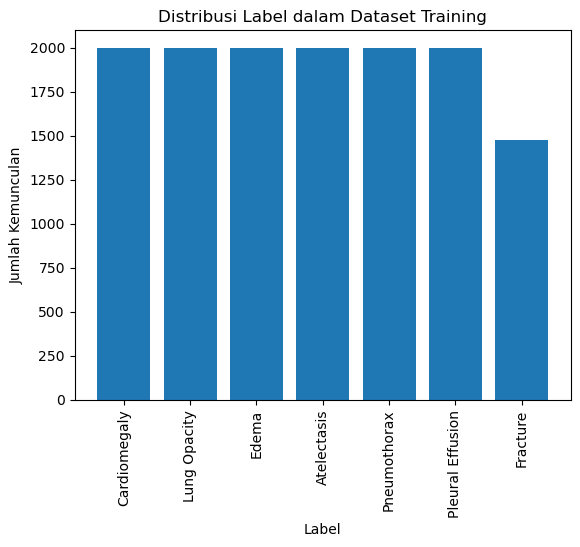


Rasio Imbalance: 1.80


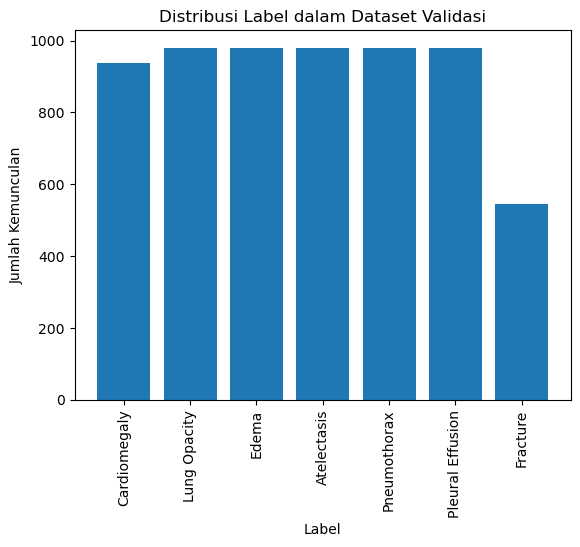

In [224]:
import random

def balance_multilabel_list(data_list, label_columns, max_per_label=10000, random_state=42):
    # Inisialisasi penghitung label
    label_counter = {label: 0 for label in label_columns}
    balanced_data = []

    # Shuffle dataset untuk menghindari urutan bias
    random.seed(random_state)
    shuffled = data_list.copy()
    random.shuffle(shuffled)

    for item in shuffled:
        labels = [label for label in item['Labels'] if label in label_columns]
        if all(label_counter[label] < max_per_label for label in labels):
            balanced_data.append(item)
            for label in labels:
                label_counter[label] += 1
        if all(count >= max_per_label for count in label_counter.values()):
            break

    return balanced_data

# Gunakan fungsi balancing
train_df = balance_multilabel_list(train_df, label_columns=label_cols, max_per_label=2000)
valid_df = balance_multilabel_list(valid_df, label_columns=label_cols, max_per_label=980)

# Hitung distribusi label
def multilabel_counts(data_list, label_columns):
    counts = {label: 0 for label in label_columns}
    for item in data_list:
        for label in item['Labels']:
            if label in counts:
                counts[label] += 1
    return counts

import matplotlib.pyplot as plt

train_label_counts = multilabel_counts(train_df, label_cols)
valid_label_counts = multilabel_counts(valid_df, label_cols)

import numpy as np
print(f"\nRasio Imbalance: {max(train_label_counts.values()) / max(1, min(train_label_counts.values())):.2f}")
plt.bar(train_label_counts.keys(), train_label_counts.values())
plt.title('Distribusi Label dalam Dataset Training')
plt.ylabel('Jumlah Kemunculan')
plt.xlabel('Label')
plt.xticks(rotation=90)
plt.show()

print(f"\nRasio Imbalance: {max(valid_label_counts.values()) / max(1, min(valid_label_counts.values())):.2f}")
plt.bar(valid_label_counts.keys(), valid_label_counts.values())
plt.title('Distribusi Label dalam Dataset Validasi')
plt.ylabel('Jumlah Kemunculan')
plt.xlabel('Label')
plt.xticks(rotation=90)
plt.show()

## Hasil Pre-procesing

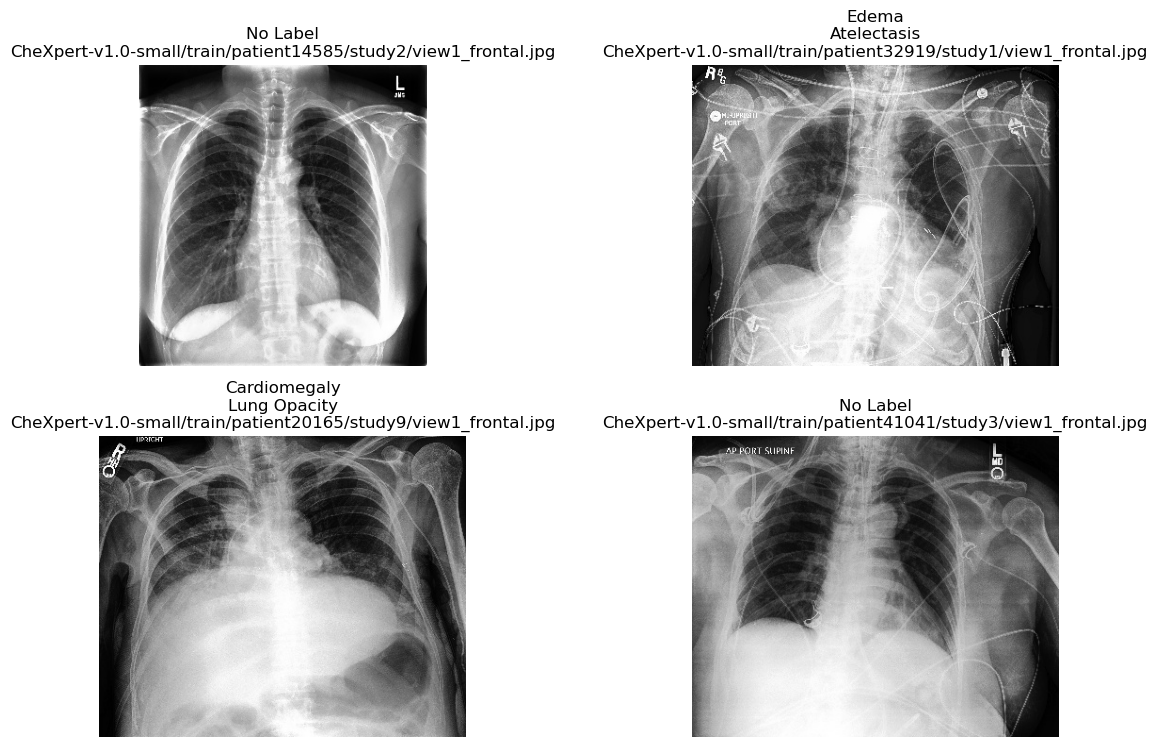

In [225]:
import random
from PIL import Image

import matplotlib.pyplot as plt

# Pilih sampel acak dari valid_df
samples = random.sample(train_df, 4)

plt.figure(figsize=(12, 15))
for i, sample in enumerate(samples):
    img_path = 'datasets/' + sample['Path']
    image = Image.open(img_path).convert('RGB')
    plt.subplot(4, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    title = ('\n'.join(sample['Labels']) if sample['Labels'] else 'No Label') + f"\n{sample['Path']}"
    plt.title(title)
plt.tight_layout()
plt.show()

## PROCESING

In [226]:
# from transformers import ViTForImageClassification, ViTConfig

# # Konfigurasi model Vision Transformer
# config = ViTConfig(
#     # image_size=224,  # Ukuran input gambar (224x224)
#     num_labels=14,   # Jumlah label output (disesuaikan dengan dataset)
#     hidden_size=768, # Ukuran dimensi hidden layer
#     num_hidden_layers=12, # Jumlah layer transformer
#     num_attention_heads=12, # Jumlah head pada multi-head attention
#     intermediate_size=3072, # Ukuran layer intermediate
#     patch_size=16,    # Ukuran patch gambar
#     hidden_dropout_prob=0.1, # Dropout pada hidden layer
#     attention_probs_dropout_prob=0.1, # Dropout pada attention
# )

# # Membuat model Vision Transformer
# model = ViTForImageClassification(config)

# # Menampilkan arsitektur model
# print(model)

### Image Transform

In [227]:
from PIL import Image
import numpy as np

def compute_mean_std(image_paths, sample_size=100):
    # Ambil sampel acak dari path gambar
    sample_paths = np.random.choice(image_paths, size=min(sample_size, len(image_paths)), replace=False)
    means = []
    stds = []
    for path in sample_paths:
        img = Image.open('datasets/' + path).convert('RGB')  # Pastikan gambar dalam format RGB
        img_np = np.array(img) / 255.0  # Normalisasi ke [0,1]
        means.append(img_np.mean(axis=(0, 1)))
        stds.append(img_np.std(axis=(0, 1)))
    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)
    return mean, std

# Kumpulkan semua path gambar dari train_df2
all_train_paths = [item['Path'] for item in train_df]
mean, std = compute_mean_std(all_train_paths, sample_size=200)
print("Mean (R,G,B):", np.round(mean, 3))
print("Std (R,G,B):", np.round(std, 3))

Mean (R,G,B): [0.507 0.507 0.507]
Std (R,G,B): [0.29 0.29 0.29]


In [228]:
# Transformasi untuk data latih

image_transforms = transforms.Compose([
    transforms.Resize(224),                # Resize sisi terpendek ke 224, aspect ratio terjaga
    transforms.CenterCrop(224),            # Crop tengah menjadi 224x224
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.502, 0.502, 0.502],
        std=[0.291, 0.291, 0.291]
    )
])
image_transforms_train  = image_transforms
image_transforms_val = image_transforms

# image_transforms_train = transforms.Compose([
#     transforms.Resize(224),                # Resize sisi terpendek ke 224, aspect ratio terjaga
#     transforms.CenterCrop(224),            # Crop tengah menjadi 224x224
#     # transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
#     # transforms.RandomHorizontalFlip(p=0.5),
#     # transforms.RandomRotation(degrees=10),
#     # transforms.ColorJitter(brightness=0.1, contrast=0.1),
#     transforms.ToTensor(),
#     # transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),  # Untuk grayscale
#     transforms.Normalize(mean=[0.502, 0.502, 0.502], std=[0.291, 0.291, 0.291])
# ])

# # Transformasi untuk data validasi
# image_transforms_val = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     # transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
#     transforms.Normalize(mean=[0.503, 0.503, 0.503], std=[0.291, 0.291, 0.291])
# ])

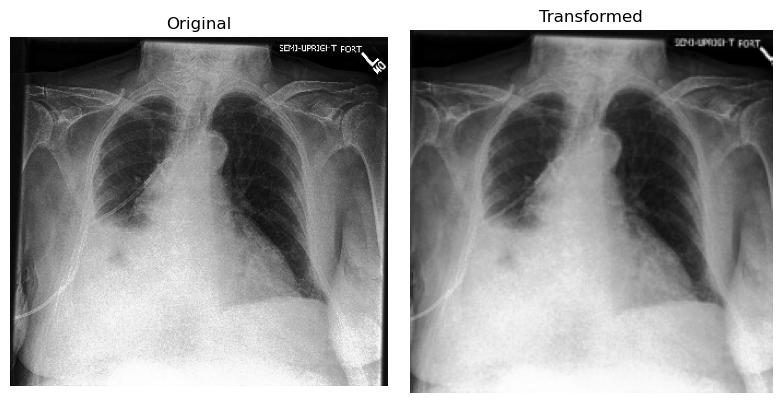

In [229]:
import matplotlib.pyplot as plt

# Pilih satu sampel dari train_df2
sample = train_df[0]
img_path = 'datasets/' + sample['Path']

# Load original image
original_image = Image.open(img_path).convert('RGB')

# Transform image
transformed_image = image_transforms(original_image)

# Untuk menampilkan tensor sebagai gambar, perlu konversi ke numpy dan unnormalize
def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone().detach().cpu().numpy()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    img = img.transpose(1, 2, 0)
    img = (img * 255).clip(0, 255).astype('uint8')
    return img

mean_np = [0.502, 0.502, 0.502]
std_np = [0.291, 0.291, 0.291]
transformed_img_disp = unnormalize(transformed_image, mean_np, std_np)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_img_disp)
plt.title('Transformed')
plt.axis('off')

plt.tight_layout()
plt.show()

### Data loader

In [230]:
class CheXpertDataset(Dataset):
     def __init__(self, data_list, label_columns, transform):
          self.data_list = data_list
          self.label_columns = list(label_columns)
          self.transform = transform

     def __len__(self):
          return len(self.data_list)

     def __getitem__(self, idx):
          item = self.data_list[idx]
          img_path = 'datasets/' + item['Path']
          image = Image.open(img_path).convert('RGB')
          image = self.transform(image)
          # Multi-hot encoding
          labels = np.zeros(len(self.label_columns), dtype=np.float32)
          for label in item['Labels']:
               if label in self.label_columns:
                    labels[self.label_columns.index(label)] = 1.0
          labels = torch.tensor(labels)
          return image, labels

# DataLoader
train_dataset = CheXpertDataset(train_df, label_cols, image_transforms_train)
valid_dataset = CheXpertDataset(valid_df, label_cols, image_transforms_val)
# Optimal DataLoader configuration for GPU performance
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)

### Pre-Train

In [231]:
from transformers import ViTFeatureExtractor

# Load pre-trained ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('WinKawaks/vit-small-patch16-224')
model = ViTForImageClassification.from_pretrained(
    'WinKawaks/vit-small-patch16-224',
    num_labels=7,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True
)

print(model)
# print("Pre-trained ViT model dan feature extractor telah dimuat.")

/opt/conda/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
            (intermed

### Optimizer

In [232]:
# # Optimizer & Loss
# optimizer = optim.AdamW(model.parameters(), lr=1e-5)
# # Asymmetric Loss implementation
# class AsymmetricLoss(nn.Module):
#     def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
#         super(AsymmetricLoss, self).__init__()
#         self.gamma_neg = gamma_neg
#         self.gamma_pos = gamma_pos
#         self.clip = clip
#         self.eps = eps

#     def forward(self, logits, targets):
#         x_sigmoid = torch.sigmoid(logits)
#         xs_pos = x_sigmoid
#         xs_neg = 1 - x_sigmoid

#         # Asymmetric Clipping
#         if self.clip is not None and self.clip > 0:
#             xs_neg = (xs_neg + self.clip).clamp(max=1)

#         # Basic CE calculation
#         loss_pos = targets * torch.log(xs_pos.clamp(min=self.eps))
#         loss_neg = (1 - targets) * torch.log(xs_neg.clamp(min=self.eps))
#         loss = loss_pos + loss_neg

#         # Asymmetric Focusing
#         if self.gamma_neg > 0 or self.gamma_pos > 0:
#             pt0 = xs_pos * targets
#             pt1 = xs_neg * (1 - targets)
#             pt = pt0 + pt1
#             one_sided_gamma = self.gamma_pos * targets + self.gamma_neg * (1 - targets)
#             loss *= (1 - pt) ** one_sided_gamma

#         return -loss.mean()

# criterion = AsymmetricLoss()

In [233]:
# # Optimizer & Loss for multi-label sigmoid (disease detection)

# # Optimizer: AdamW is robust for transformers
# # optimizer = optim.AdamW(model.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)

# Loss: Binary Cross Entropy with Logits is standard for multi-label sigmoid
criterion = nn.BCEWithLogitsLoss()

### Fine Tune


Epoch 4: Train Loss: 0.2382 | Val Loss: 0.2857 | Val Acc: 90.53%


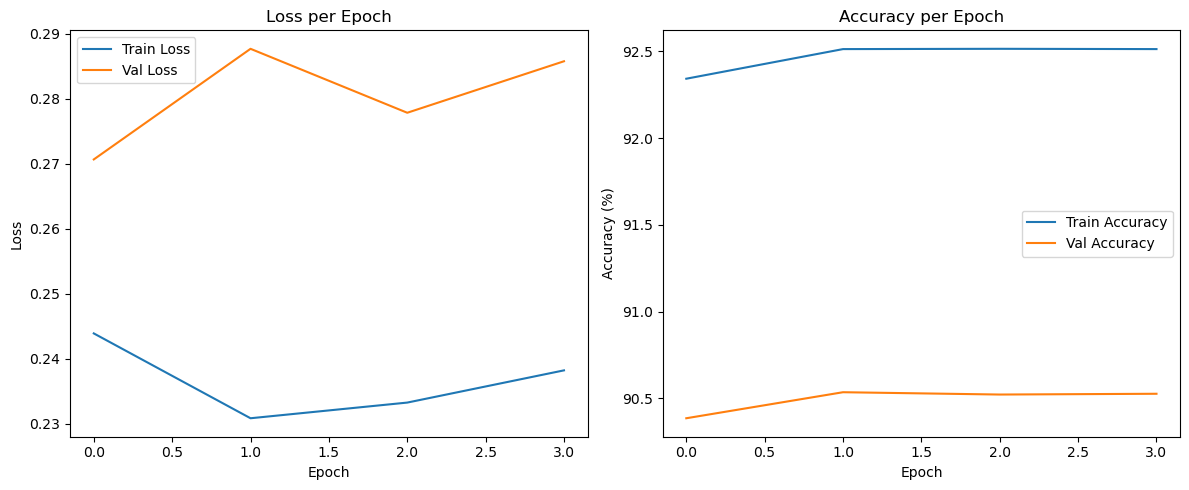


Early stopping triggered after 4 epochs!


Training complete!
Best Validation Loss: 0.2706
Best Validation Accuracy: 90.54%
-----------------------------------------------------------------------
Best Training Loss: 0.2308
Best Training Accuracy: 92.51%


In [234]:
# Fine-tuning pre-trained ViT model with enhancements
num_epochs = 50  # Increased for early stopping demonstration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define scheduler as None if not using a learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=5)

# Early Stopping Setup
patience = 3  # Berhenti jika tidak ada perbaikan dalam 3 epoch
best_val_loss = np.inf # Menyimpan loss validasi terbaik
epochs_without_improvement = 0 # Penghitung epoch tanpa perbaikan

# Tracking history
train_acc_history = []
train_loss_history = []
val_loss_history = []
val_acc_history = []

# Mixed precision training
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available(), growth_interval=2)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training loop with mixed precision
    train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for images, targets in train_loop:
        images = images.to(device, non_blocking=True)  # Pindahkan ke device secara async
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # More efficient memory-wise
        
        # Mixed precision forward/backward
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(images).logits
            loss = criterion(outputs, targets)
        
        scaler.scale(loss).backward() # Backpropagation dengan scaling
        scaler.step(optimizer) # Update weights
        scaler.update() # Update scaler

        running_loss += loss.item() * images.size(0)
        train_loop.set_postfix(loss=loss.item())
        
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == targets).sum().item()
        train_total += targets.numel()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)
    train_accuracy = 100 * train_correct / train_total
    train_acc_history.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_loop = tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
    with torch.no_grad():
        for images, targets in val_loop:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            outputs = model(images).logits
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == targets).sum().item()
            total += targets.numel()  # total elemen label
            
            val_loop.set_postfix(val_loss=loss.item())

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100 * correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)
    
    clear_output(wait=True)
    print(f"\nEpoch {epoch+1}: Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # Tambahkan kode ini untuk plotting realtime
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!\n")
            break

    # Learning rate scheduling (optional)
    if scheduler is not None:
        scheduler.step(val_loss)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print("\nTraining complete!")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {max(val_acc_history):.2f}%")
print("-----------------------------------------------------------------------")
print(f"Best Training Loss: {min(train_loss_history):.4f}")
print(f"Best Training Accuracy: {max(train_acc_history):.2f}%")

In [235]:
print(f"Best Validation Loss: {best_val_loss:.4f}%")
print(f"Best Validation Accuracy: {max(val_acc_history):.2f}%")
print("-----------------------------------------------------------------------")
print(f"Best Training Loss: {min(train_loss_history):.4f}%")
print(f"Best Training Accuracy: {max(train_acc_history):.2f}%")

Best Validation Loss: 0.2706%
Best Validation Accuracy: 90.54%
-----------------------------------------------------------------------
Best Training Loss: 0.2308%
Best Training Accuracy: 92.51%


## Pasca-Procesing

### Test

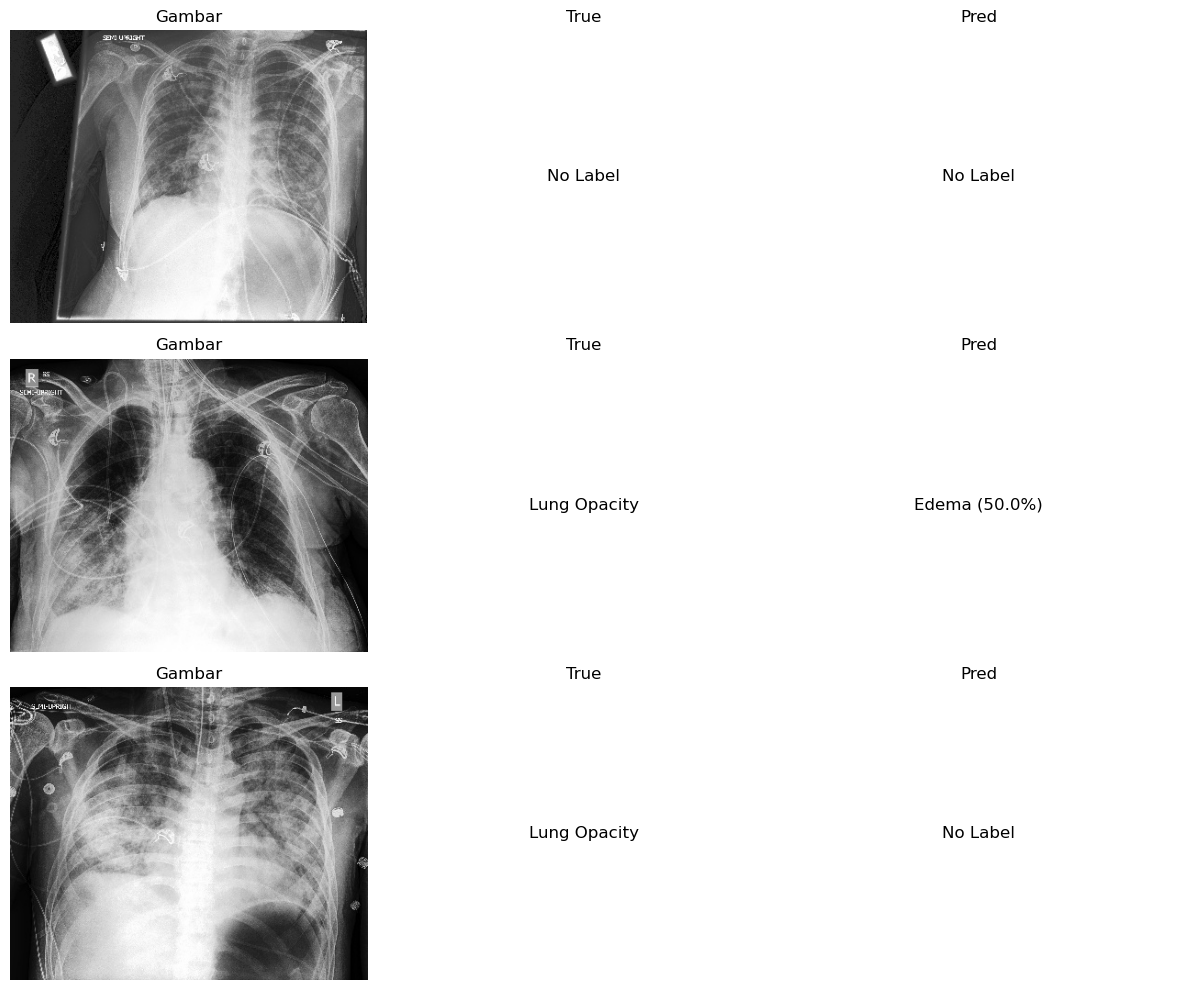

In [245]:
import random
import matplotlib.pyplot as plt

# Load best model weights sebelum inferensi
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

# Ambil 3 sampel acak dari test_df
samples = random.sample(test_df, 3)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))

for i, sample in enumerate(samples):
    img_path = 'datasets/' + sample['Path']
    image = Image.open(img_path).convert('RGB')
    input_tensor = image_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor).logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        pred = (probs > 0.5)
    pred_labels = [f"{label_cols[j]} ({probs[j]*100:.1f}%)" for j, v in enumerate(pred) if v]
    true_labels = sample['Labels']

    # Kolom 0: Gambar
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Gambar")

    # Kolom 1: True label
    axes[i, 1].text(0.5, 0.5, '\n'.join(true_labels) if true_labels else 'No Label',
                    fontsize=12, ha='center', va='center')
    axes[i, 1].axis('off')
    axes[i, 1].set_title("True")

    # Kolom 2: Pred label + presentase
    axes[i, 2].text(0.5, 0.5, '\n'.join(pred_labels) if pred_labels else 'No Label',
                    fontsize=12, ha='center', va='center')
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Pred")

plt.tight_layout()
plt.show()


In [247]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

import matplotlib.pyplot as plt

# Kumpulkan prediksi dan target untuk seluruh test set
all_targets = []
all_preds = []

# Convert label_columns to list for .index() usage
label_columns_list = list(label_cols)

for sample in test_df:
    img_path = 'datasets/' + sample['Path']
    image = Image.open(img_path).convert('RGB')
    input_tensor = image_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor).logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        pred = (probs > 0.5).astype(int)
    # Multi-hot encoding untuk label ground truth
    target = np.zeros(len(label_cols), dtype=int)
    for label in sample['Labels']:
        if label in label_columns_list:
            target[label_columns_list.index(label)] = 1
    all_targets.append(target)
    all_preds.append(pred)

all_targets = np.array(all_targets)
all_preds = np.array(all_preds)

# Hitung confusion matrix untuk setiap label
cm = multilabel_confusion_matrix(all_targets, all_preds)

fig, axes = plt.subplots(2, 7, figsize=(22, 7))
axes = axes.flatten()

for i, (ax, label) in enumerate(zip(axes, label_columns)):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(label)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 